**<h1 style="text-align:center"><font size = "15" >Q1. Kernel k-means</font></h1>**
***

### Let's try and end our course on a happy note. The smiley dataset you see below is made up of many clusters of points. 

In [1]:
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
from matplotlib import pyplot as plt
import pandas as pd
import sys

def getFigure( sizex = 7, sizey = 7 ):
    fig = plt.figure( figsize = (sizex, sizey) )
    return fig

def plot2D( X, fig, color = 'r', marker = '+', size = 100, empty = False ):
    plt.figure( fig.number )
    if empty:
        plt.scatter( X[:,0], X[:,1], s = size, facecolors = 'none', edgecolors = color, marker = marker  )
    else:
        plt.scatter( X[:,0], X[:,1], s = size, c = color, marker = marker )


def genCrescentData( d, n, mu, r, flipped = False ):
    X = np.vstack( (np.cos( np.linspace( 0, np.pi, n ) ), np.sin( np.linspace( 0, np.pi, n ) ) ) ).T
    if flipped:
        X[:,1] = -np.abs( X[:,1] )
    else:
        X[:,1] = np.abs( X[:,1] )
    X = (X * r) + mu
    return X

def genSphericalData( d, n, mu, r ):
    X = rnd.normal( 0, 1, (n, d) )
    norms = lin.norm( X, axis = 1 )
    X = X / norms[:, np.newaxis]
    X = (X * r) + mu
    return X

In [2]:
d = 2
n = 200

mu1 = np.array( [0,0] )
mu2 = np.array( [0,1] )
mu3 = np.array( [0,0] )
mu4 = np.array( [-3,5] )
mu5 = np.array( [3,5] )

tmp1 = genCrescentData( d, n, mu1, 1 )
tmp2 = genCrescentData( d, n, mu2, 5, flipped = True )
tmp3 = genSphericalData( d, n, mu3, 10 )
tmp4 = genSphericalData( d, n, mu4, 1 )
tmp5 = genSphericalData( d, n, mu5, 1 )
Y = np.vstack( (tmp1, tmp2, tmp3, tmp4, tmp5) )

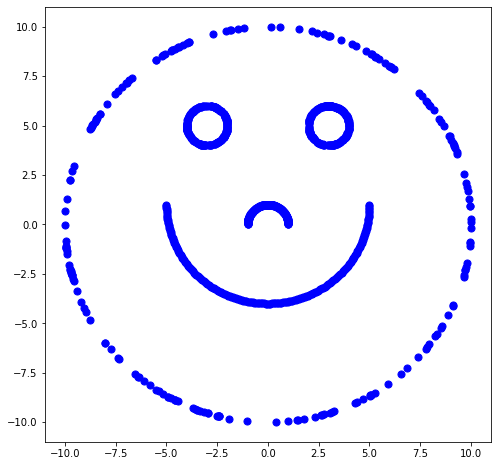

In [3]:
fig = getFigure( 8, 8 )
plot2D( Y, fig, size = 50, color = 'b', marker = 'o' )

In [4]:
#Merging all data
data = np.append(tmp1,tmp2,axis=0)
data = np.append(data,tmp3,axis=0)
data = np.append(data,tmp4,axis=0)
data = np.append(data,tmp5,axis=0)

df1 = pd.DataFrame(data)
df = df1.copy()

### (a) Can you implement the k-means algorithm to cluster this dataset? Visualize your output. 

K-means algorithm is an unsupervised learning algorithm. We are given a data set of items, with certain features, and values for these features (like a vector). The task is to categorize those items into groups. The algorithm will categorize the items into k groups of similarity. To calculate that similarity, we will use the euclidean distance as measurement.

The algorithm works as follows: 

- First, we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

The “points” mentioned above are called means because they hold the mean values of the items categorized in them.

In [5]:
#Defining a function to implement kmeans algo
def k_means(df,k=3):
    np.random.seed(42)

    #Initializing cluster means for clusters(here k)
    cluster_means = {
        i+1: [np.random.randint(np.min(df[0]),np.max(df[0])),np.random.randint(np.min(df[1]),np.max(df[1]))]
        for i in range(k)
    }
    
    #Calculating the distance of each point from the means and assigning them to the dataframe
    def assign(df,cluster_means):
        for i in cluster_means.keys():

            #Formula : sqrt((x1-x2)^2 - (y1-y2)^2)
            df["distance_from_{}".format(i)] = (np.sqrt((df[0] - cluster_means[i][0])**2 + (df[1] - cluster_means[i][1])**2))

        cluster_means_dis_cols = ["distance_from_{}".format(i) for i in cluster_means.keys()]
    
        #Adding closest cluster mean column
        df["closest"] = df.loc[:,cluster_means_dis_cols].idxmin(axis=1)
        df["closest"] = df["closest"].map(lambda x: int(x.lstrip("distance_from_")))
    
        #Returning created dataframe
        return df
    
    #Creating initial dataframe which will be modified later on 
    df = assign(df,cluster_means)

    #Function to update the mean of each cluster
    def update(k):
        for i in cluster_means.keys():
            cluster_means[i][0] = np.mean(df[df["closest"] == i][0])
            cluster_means[i][1] = np.mean(df[df["closest"] == i][1])
        
        return k
    
    #Repeating assign and update functions till convergance to get the optimal cluster means
    while True:
        cluster_means_closest= df["closest"].copy(deep=True)
        #Updating cluster means
        cluster_means = update(cluster_means)
        #Assigning the updated dataframe of distances for updated cluster means
        df = assign(df,cluster_means)
        #Condition to break out of the loop
        if cluster_means_closest.equals(df["closest"]):
            break
        
    return df

#Function to plot the data according to clusters
def plot2d(result, k=3):
    #Defining the figure size
    plt.figure( figsize = (8, 8) )
    x = []
    #Iterating over values in range(k)
    for i in range(k):
        i = i + 1
        x.append(result.query("closest == @i"))

    #List of Colors to use in the plot to denote different clusters
    clr = ["r","g","b","y","c","m","k"]

    #Plotting cluster points
    for i in range(k):
        plt.scatter(x[i][0],x[i][1],color = clr[i])
    

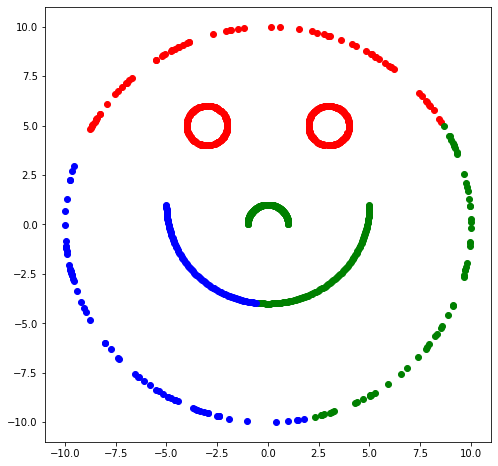

In [6]:
#Passing k =3 in kmeans algo
result = k_means(df,3)

#Plotting the result
plot2d(result, 3)

### (b) Implement k-means++ to initialize cluster centers usefully. 

Drawback of standard K-means algorithm:

One disadvantage of the K-means algorithm is that it is sensitive to the initialization of the centroids or the mean points. So, if a centroid is initialized to be a “far-off” point, it might just end up with no points associated with it, and at the same time, more than one cluster might end up linked with a single centroid. Similarly, more than one centroids might be initialized into the same cluster resulting in poor clustering.

To overcome the above-mentioned drawback we use K-means++. This algorithm ensures a smarter initialization of the centroids and improves the quality of the clustering. Apart from initialization, the rest of the algorithm is the same as the standard K-means algorithm. That is K-means++ is the standard K-means algorithm coupled with a smarter initialization of the centroids.

Initialization algorithm:
The steps involved are: 

1.   Randomly select the first centroid from the data points.
2.   For each data point compute its distance from the nearest, previously chosen centroid.
3.   Select the next centroid from the data points such that the probability of choosing a point as centroid is directly proportional to its distance from the nearest, previously chosen centroid. (i.e. the point having maximum distance from the nearest centroid is most likely to be selected next as a centroid)
4.   Repeat steps 2 and 3 until k centroids have been sampled

In [7]:
#Function to compute Euclidean Distance
def dist(pt1, pt2):
    return np.sum((pt1 - pt2)**2)

def initial(data, k):
    #Initializing the cluster means for K-means++
    #inputs:
    #   data - numpy array of data points having shape (200, 2)
    #   k - number of clusters

    #Initialize the cluster means list
    cluster_mean = []
    #Selecting a random data point and adding it to the list
    cluster_mean.append(data[np.random.randint(data.shape[0]), :])
  
    #Compute remaining k-1 centroids by iterating following code k-1 times
    for cl_id in range(k - 1):
         
        #Initialize a list to store distances 
        dis = []
        #Storing distances of data points from nearest cluster mean
        for i in range(data.shape[0]):
            pt = data[i, :]
            #Maximum
            d = sys.maxsize
             
            #Computing distance of a point from each of the previously derived cluster means and storing the minimum distance
            for j in range(len(cluster_mean)):
                tmp_dis = dist(pt, cluster_mean[j])
                d = min(d, tmp_dis)
            dis.append(d)
             
        #Select data point with maximum distance as our next centroid
        dis = np.array(dis)
        next_cluster_means = data[np.argmax(dis), :]
        cluster_mean.append(next_cluster_means)
        dis = []

    return cluster_mean

#Defining a function to implement kmeans++ algo
def kmeans_plus_plus(df,k=3):
    np.random.seed(42)

    #Call the initial function to get the cluster mean
    cluster_mean = initial(data, k)

    #Initializing cluster means for clusters(here k)
    cluster_means = {
        i+1 : cluster_mean[i]
        for i in range(k)
    }

    #Calculating distance of each point from the means and assigning them to dataframe
    def assign(df,cluster_means):
        for i in cluster_means.keys():

            #Formula : sqrt((x1-x2)^2 - (y1-y2)^2)
            df["distance_from_{}".format(i)] = (np.sqrt((df[0] - cluster_means[i][0])**2 + (df[1] - cluster_means[i][1])**2))
        
        cluster_means_dis_cols = ["distance_from_{}".format(i) for i in cluster_means.keys()]
        
        #Adding closest cluster mean column
        df["closest"] = df.loc[:,cluster_means_dis_cols].idxmin(axis=1)
        df["closest"] = df["closest"].map(lambda x: int(x.lstrip("distance_from_")))
    
        #Returning created dataframe
        return df
    
    #Creating initial dataframe which will be modified later on
    df = assign(df,cluster_means)
    
    #Function to update the mean of each cluster 
    def update(k):
        for i in cluster_means.keys():
            cluster_means[i][0] = np.mean(df[df["closest"] == i][0])
            cluster_means[i][1] = np.mean(df[df["closest"] == i][1])
        
        return k
    
    #Repeating assign and update functions till convergance to get the optimal cluster means
    while True:
        cluster_means_closest = df["closest"].copy(deep=True)
        #Updating cluster means
        cluster_means = update(cluster_means)
        #Assigning the updated dataframe of distances for updated cluster means
        df = assign(df,cluster_means)
        #Condition to break out of the loop
        if cluster_means_closest.equals(df["closest"]):
            break
        
    return [df,cluster_mean]

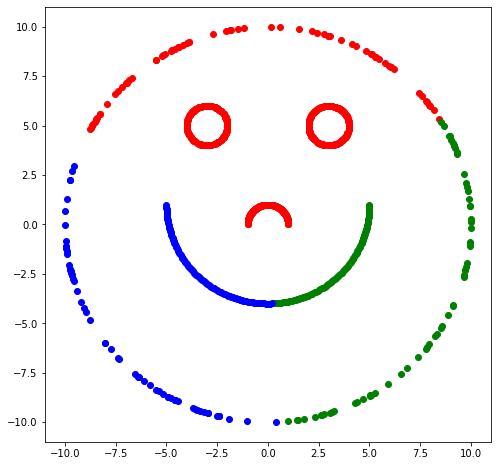

In [8]:
#Passing k = 3 in kmeans++ algo
result = kmeans_plus_plus(df,3)

#Plotting the result
plot2d(result[0], 3)

### What value of k gives you the best clustering? Are you happy with the quality of the clustering? 

A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

The idea behind elbow method is to run k-means clustering on a given dataset for a range of values of k (num_clusters, e.g k=1 to 10), and for each value of k, calculate sum of squared errors (SSE).

After that, plot a line graph of the SSE for each value of k.

The "elbow" in the graph is the value of optimal k (number of cluster). Here, we want to minimize SSE. SSE tends to decrease toward 0 as we increase k (and SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster).

So the goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.

In [9]:
#Function to get the sum of squared errors (SSE) for the cluster means
def sse(df,cluster_means,k):
    #Creating SSE list to store SSE
    sse = []
    for i in range(k):
        i += 1
        temp = df.query("closest == @i")
        #Getting SSE for single instance
        x = np.sqrt((temp[0] - cluster_means[i-1][0])**2 + (temp[1] - cluster_means[i-1][1])**2)
        sse.append(np.sum(x))

    #Returning SSE    
    return np.sum(sse)

In [10]:
#Elbow Function to get SSE's for a range of k values
def elbow(k = 3):
    #Creating list to store SSE's for different k values
    elbo = []
    for i in range(1,k+1):
        #Running kmeans++ for each k value and getting elbo
        result = kmeans_plus_plus(df,i)
        elbo.append(sse(result[0],result[1],i))
    
    #Returning list elbo
    return elbo

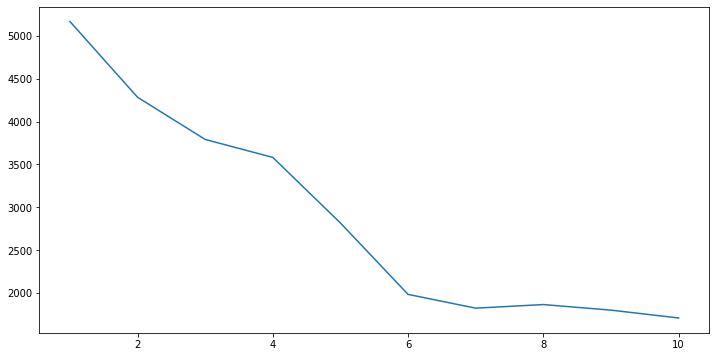

In [11]:
#Running elbow for maximum k value = 10
s = elbow(10)

#Plotting the graph of SSE vs k values
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(list(range(1,11)),s);

### From above elbow graph it is clear that the best k values is 6

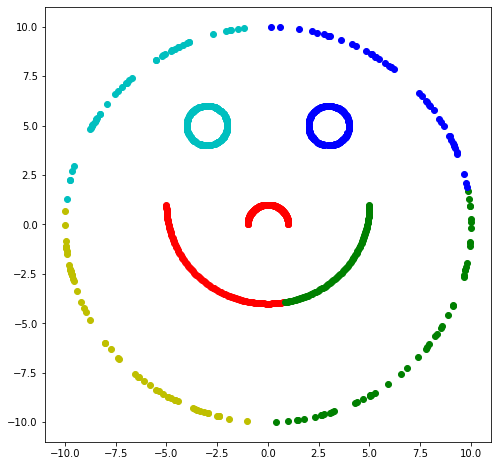

In [12]:
#Passing k = 3 in kmeans++ algo
result = kmeans_plus_plus(df,5)

#Plotting the result
plot2d(result[0], 5)

### (d) I'm going to say that we want to be able to do better than this. So I want you to kernelize your k-means algorithm with a Gaussian kernel. Visualize the clustering output of your kernel k-means algorithm

The k-means clustering algorithm can be enhanced by the
use of a kernel function; by using an appropriate nonlinear
mapping from the original (input) space to a higherdimensional
feature space, one can extract clusters that are
non-linearly separable in input space.

The basic idea in kernel k-means is to replace the Euclidean distance/similarity computations in K-means by the kernelized versions.

Advantages

1) Algorithm is able to identify the non-linear structures.

2) Algorithm is best suited for real life data set.

In [13]:
def getPairsDistances( A, B ):
        squaredNormsA = np.square( lin.norm( A, axis = 1 ) )
        squaredNormsB = np.square( lin.norm( B, axis = 1 ) )
        return squaredNormsA[:, np.newaxis] + squaredNormsB - 2 * A.dot( B.T )
def getMatrix( X, Y,g = 0.25 ):
    # Check if these are 1D datasets
    if len( X.shape ) == 1:
        X = X[:, np.newaxis]
    if len( Y.shape ) == 1:
        Y = Y[:, np.newaxis]
    
    return np.exp( - g * getPairsDistances( X, Y ) )

In [14]:
G = getMatrix( data, data,g=0.25)
df = pd.DataFrame(G)
df["x"] = Y[:,0]
df["y"] = Y[:,1]

In [15]:
#Defining a function to implement kmeans algo
def k_means(df,k=3):

    #Initializing cluster means for clusters(here k)
    cluster_means = {
        i+1: G[np.random.randint(G.shape[0]), :]
        for i in range(k)
    }
    
    #Calculating the distance of each point from the means and assigning them to the dataframe
    def assign(df,cluster_means):
        for i in cluster_means.keys():
            
            #Formula : sqrt((x1-x2)^2 - (y1-y2)^2)
            b = 0
            for j in range(1000):
                b += (df[j] - cluster_means[i][j])**2
                df["distance_from_{}".format(i)] = np.sqrt(b)

        cluster_means_dis_cols = ["distance_from_{}".format(i) for i in cluster_means.keys()]
    
        #Adding closest cluster mean column
        df["closest"] = df.loc[:,cluster_means_dis_cols].idxmin(axis=1)
        df["closest"] = df["closest"].map(lambda x: int(x.lstrip("distance_from_")))
    
        #Returning created dataframe
        return df
    
    #Creating initial dataframe which will be modified later on 
    df = assign(df,cluster_means)

    #Function to update the mean of each cluster
    def update(k):
        for i in cluster_means.keys():
            for j in range(1000):
                cluster_means[i][j] = np.mean(df[df["closest"] == i][j])
        
        return k
    
    #Repeating assign and update functions till convergance to get the optimal cluster means
    while True:
        cluster_means_closest= df["closest"].copy(deep=True)
        #Updating cluster means
        cluster_means = update(cluster_means)
        #Assigning the updated dataframe of distances for updated cluster means
        df = assign(df,cluster_means)
        #Condition to break out of the loop
        if cluster_means_closest.equals(df["closest"]):
            break
        
    return df

def plot2d(result, k=3):
    #Defining the figure size
    plt.figure( figsize = (8, 8) )
    x = []
    #Iterating over values in range(k)
    for i in range(k):
        i = i + 1
        x.append(result.query("closest == @i"))

    #List of Colors to use in the plot to denote different clusters
    clr = ["r","g","b","y","c","m","k"]

    #Plotting cluster points
    for i in range(k):
        plt.scatter(x[i]["x"],x[i]["y"],color = clr[i])

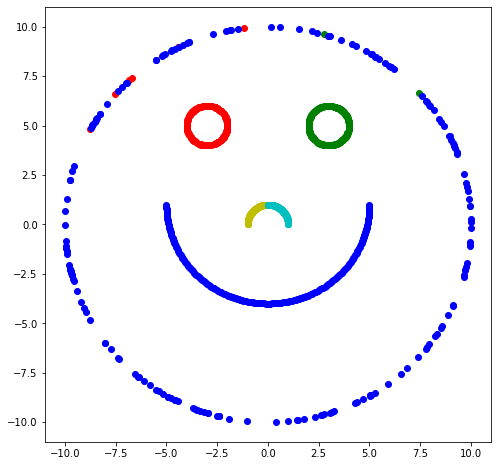

In [16]:
#Passing k =3 in kmeans algo
result = k_means(df,5)

#Plotting the result
plot2d(result, 5)

***

**<h1 style="text-align:center"><font size = "15" >Q2. Expectation-Maximization</font></h1>**
***

## (a) Can you derive the E-step and M-step for an EM algorithm that would work for a Gaussian mixture model wherein the mixture weights $\pi_k$ are known, and the covariances are restricted to be spherical, i.e. $\Sigma_k = \sigma^2_k I$? [20 points]

### Note :  $ \Theta = {\big\{ \mu_k,\sigma_k^2 \big\}}_{k=1}^K $ and $ x_n \in R^D $
### Let us first evaluate some basic notations : 
### 1)
$
\Large p(z_n=k|x_n, \hat{\Theta}) \propto p(z_n = k|\hat{\Theta}) * p(x_n|z_n = k,\hat{\Theta})
$
$
\Large = \pi_k * N \Big( x_n|\widehat{\mu_k},\widehat{\sigma_k^2}I_D \Big)
$
### Also
### 2)
$
\Large \hat{\Theta} = argmax_\Theta E_{p(Z|X, \hat{\Theta})} \big[ log (p(X,Z| \Theta)) \big]
$
$
\Large = argmax_\Theta E_{p(Z|X, \hat{\Theta})} \bigg[ \sum_{n=1}^N log(p(x_n, z_n|\Theta)) \bigg]
$
$
\Large we\;have\;p(x_n,z_n| \Theta) = \sum_{k=1}^K(p(z_n = k| \Theta) * p(x_n|z_n = k, \Theta))^{z_{nk}} 
$
$
\Large where\;z_{nk} = 1\;when\;x_n\;belongs\;to\;k^{th}\;cluster,\;else\;z_{nk} = 0
$
$
\Large = argmax_\Theta E \bigg[ \sum_{n=1}^N \sum_{k=1}^K z_{nk} \big[log\pi_k + log N \big( x_n|\mu_k, \sigma_k^2I_D \big) \big] \bigg]
$
$
\Large using\;Expectation\;of\;z_{nk}
$
$
\Large = argmax_\Theta \sum_{n=1}^N \sum_{k=1}^K E_{p(z_n|x_n,\hat{\Theta})}\big[ z_{nk} \big] \big[ log\pi_k + log N \big( x_n|\mu_k, \sigma_k^2I_D \big) \big]
$
- ## Expectation Step
### &emsp; &emsp;Using 1)
$
\Large E[z_{nk}] = \gamma_{nk}
$
$
\Large = 0 * p(z_{nk} = 0 | x_n, \hat{\Theta}) + 1 * p(z_{nk} = 1 | x_n, \hat{\Theta})
$
$
\Large =\frac{\pi_k*N \Big( x_n|\hat{\mu_k}, \widehat{\sigma_k^2}I_D \Big)}{\sum_{i=1}^K \pi_i*N \Big( x_n|\widehat{\mu_i}, \widehat{\sigma_k^2} I_D \Big)}
$
$
\Large N_k = \sum_{n=1}^N \gamma_{nk}
$
- ## Maximization Step
$
\Large =argmax_\Theta \sum_{n=1}^N \sum_{k=1}^K E_{p(z_n|x_n,\hat{\Theta})}[z_{nk}]\big[ log\pi_k + logN \big( x_n|\mu_k, \sigma_k^2I_D \big) \big]
$
$
\Large \hat{\Theta}=argmax_\Theta \sum_{n=1}^N \sum_{k=1}^K E_{p(z_n|x_n,\hat{\Theta})}[z_{nk}]\big[ log\pi_k + logN \big( x_n|\mu_k, \sigma_k^2I_D \big) \big]
$
$
\Large \hat{\Theta}=argmax_\Theta \sum_{n=1}^N \sum_{k=1}^K \gamma_{nk}\big[ log\pi_k + logN \big( x_n|\mu_k, \sigma_k^2I_D \big) \big]
$
$
\Large =argmax_\Theta \sum_{n=1}^N \sum_{k=1}^K \gamma_{nk}\left[ log\pi_k + log\frac{1}{\sqrt{{(2\pi)}^D |\sigma_k^2I_D|}}exp\left( -\frac{1}{2}(x_n-\mu_k)^T \frac{I_D}{\sigma_k^2}(x_n-\mu_k) \right) \right]
$
$
\Large =argmax_\Theta \sum_{n=1}^N \sum_{k=1}^K \gamma_{nk}\left[ log\pi_k + log\frac{1}{{(2\pi)}^{D/2}{(\sigma_k^2)}^{D/2}}exp\left( -\frac{1}{2}(x_n-\mu_k)^T \frac{I_D}{\sigma_k^2}(x_n-\mu_k) \right) \right]
$
$
\Large =argmax_\Theta \sum_{n=1}^N \sum_{k=1}^K \gamma_{nk}\left[ log\pi_k - \frac{D}{2}log(2\pi) - \frac{D}{2}log(\sigma_k^2) -\left( \frac{1}{2\sigma_k^2}(x_n-\mu_k)^T \frac{I_D}{\sigma_k^2}(x_n-\mu_k) \right) \right]
$
### &emsp; &emsp; To find the MLE estimates of $\mu_k$ and $\sigma_k^2$, we will take the partial derivative of the above expression with respect to $\mu_k$ and $\sigma_k^2$

- ## Finding $\mu_k$
$
\Large \large \frac {\partial \hat{\Theta}}{\partial \mu_k}
$
$
\Large \text{All the terms not belonging to the cluster of the parameter under consideration will go to 0}
$
$
\Large \Longrightarrow \sum_{n=1}^N \gamma_{nk} \bigg[ - \frac{\partial}{\partial\mu_k} \bigg( \frac{1}{2\sigma_k^2}(x_n-\mu_k)^TI_D(x_n-\mu_k)\bigg)\bigg] = 0
$
$
\Large \Longrightarrow \sum_{n=1}^N \gamma_{nk} \bigg[ - \bigg(\frac{(x_n-\mu_k)}{\sigma_k^2} \bigg) \bigg] = 0
$
$
\Large \Longrightarrow \sum_{n=1}^N -\gamma_{nk}(x_n - \mu_k) = 0
$
$
\Large \Longrightarrow \sum_{n=1}^N - \gamma_{nk}x_n + \sum_{n=1}^N \gamma_{nk}\mu_k = 0
$
$
\Large \Longrightarrow \mu_k \sum_{n=1}^N \gamma_{nk} = \sum_{n=1}^N \gamma_{nk}x_n
$
$
\Large \Longrightarrow \mu_k = \frac{\sum_{n=1}^N\gamma_{nk}x_n}{\sum_{n=1}^N \gamma_{nk}}
$
$
\Large \Longrightarrow \mu_k = \frac{\sum_{n=1}^N \gamma_{nk}x_n}{N_k}
$
- ## Finding $\sigma_k^2$
$
\Large \frac{\partial \hat{\Theta}}{\partial \sigma_k^2} = 0
$
$
\Large \text{All the terms not belonging to the cluster whose parameter is under consideration will go to 0}
$
$
\Large \Longrightarrow \sum_{n=1}^N \gamma_{nk} \frac{\partial}{\partial \sigma_k^2} \bigg[ -\frac{D}{2} log(\sigma_k^2) - \bigg( \frac{1}{2\sigma_k^2}(x_n-\mu_k)^TI_D(x_n-\mu_k) \bigg) \bigg] = 0
$
$
\Large \Longrightarrow \sum_{n=1}^N \gamma_{nk} \bigg[ - \frac{D}{2\sigma_k^2} - \bigg( -\frac{1}{2{(\sigma_k^2)}^2}(x_n-\mu_k)^TI_D(x_n-\mu_k) \bigg) \bigg] = 0
$
$
\Large \Longrightarrow \sum_{n=1}^N \gamma_{nk} \big[ D\sigma_k^2-(x_n-\mu_k)^TI_D(x_n-\mu_k) \big] = 0
$
$
\Large \Longrightarrow \sum_{n=1}^N \gamma_{nk} D \sigma_k^2 = \sum_{n=1}^N \gamma_{nk}(x_n - \mu_k)^T(x_n - \mu_k)
$
$
\Large \Longrightarrow D\sigma_k^2 \sum_{n=1}^N \gamma_{nk} = \sum_{n=1}^N \gamma_{nk} (x_n - \mu_k)^T(x_n - \mu_k)
$
$
\Large \Longrightarrow \sigma_k^2 = \frac{\sum_{n=1}^N \gamma_{nk} (x_n - \mu_k)^T (x_n - \mu_k)}{N_kD}
$
- ## The EM Algorithm proceeds as follows : 
### &emsp; &emsp;1. Initialization
### &emsp; &emsp;Set $\Theta = {\big\{ \mu_k,\sigma_k^2 \big\}}_{k=1}^K $ as $\Theta^0 $ and $t = 0$

### &emsp; &emsp;2.E-Step
$
\Large E[z_{nk}] = \gamma_{nk} = \frac{\pi_k * N \Big( x_n|\mu_k^{t-1}, {\big( \sigma_k^2 \big) }^{t-1}I_D \Big)}{\sum_{i=1}^K \pi_i * N \Big( x_n|\mu_k^{t-1}, {\big( \sigma_k^2 \big)}^{t-1}I_D}
$
$
\Large N_k = \sum_{n=1}^N \gamma_{nk}
$

### &emsp; &emsp;3.M-Step
$
\Large \mu_k^t = \frac{\sum_{n=1}^N \gamma_{nk}^t x_n}{N_k^t}
$
$
\Large {\big( \sigma_k^2 \big)}^t = \frac{\sum_{n=1}^N \gamma_{nk}^t (x_n - \mu_k^t)^T (x_n - \mu_k^t)}{N_k^tD}
$

## (b) Implement this algorithm and show that it works on synthetic data with 3 clusters. If you are unable to derive the EM algorithm for part (a), implement the EM algorithm I showed in the class slides for the standard GMM (5 point penalty for taking this option) [15 points]. 

In [17]:
#Multivariate Gaussian Distribution
from scipy.stats import multivariate_normal

In [18]:
#Bivariate Gaussian Distribution
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                 mux=0.0, muy=0.0, sigmaxy=0.0):
    
    #Bivariate Gaussian distribution for equal shape *X*, *Y*.
    #This function previously was available in matplotlib.mlab version below v3.1.0 
    #But got removed later so pre-defining this function
    Xmu = X-mux
    Ymu = Y-muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

In [19]:
#Function to compute log(\sum_i exp(Z_i)) for some array Z
def logsumexp(Z):
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))

#Function to compute the loglikelihood of the data for a Gaussian mixture model with the given parameters.
def loglikelihood(dat, wgts, mns, covs):
    #Getting number of clusters
    num_clusts = len(mns)
    num_dim = len(dat[0])
    
    #Initializing with 0
    loli = 0
    for d in dat:
        
        zn = np.zeros(num_clusts)
        #Iterating for the number of clusters
        for k in range(num_clusts):
            
            #Compute (x-mu)^T * Sigma^{-1} * (x-mu)
            delt = np.array(d) - mns[k]
            exponent_term = np.dot(delt.T, np.dot(np.linalg.inv(covs[k]), delt))
            
            #Compute loglikelihood contribution for this data point and this cluster
            zn[k] += np.log(wgts[k])
            zn[k] -= 1/2. * (num_dim * np.log(2*np.pi) + np.log(np.linalg.det(covs[k])) + exponent_term)
            
        #Increment loglikelihood contribution of this data point across all clusters
        loli += logsumexp(zn)
    
    #Returning loglikelihood
    return loli

In [20]:
#E-step: 
#Function to compute responsibilities, given the current parameters
def comp_respons(dat, wgts, mns, covs):
    num_dat = len(dat)
    #Number of Clusters
    num_clusts = len(mns)
    respon = np.zeros((num_dat, num_clusts))
    
    #Update responsibility matrix so that respon[i,k] is the responsibility of cluster k for data point i.
    for i in range(num_dat):
        for k in range(num_clusts):
            respon[i, k] = wgts[k]*multivariate_normal.pdf(dat[i], mean=mns[k], cov=covs[k])
    
    #Add up responsibilities over each data point and normalize appropriately
    sum_rows = respon.sum(axis=1)[:, np.newaxis]
    respon = respon / sum_rows
    
    #Returning updated responsibilities
    return respon

In [21]:
#Function to compute the total responsibility assigned to each cluster, which will be useful when
#implementing M-steps below. In the lectures this is called N^{soft}
def comp_cnts(respon):
    cnts = np.sum(respon, axis=0)

    #Returning total responsibility
    return cnts

In [22]:
#Function to update means for cluster k using the M-step update rule for the mean variables.
# This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
def comp_mns(dat, respon, cnts):
    #Number of Clusters
    num_clusts = len(cnts)
    num_dat = len(dat)
    mns = [np.zeros(len(dat[0]))] * num_clusts
    
    #Iterating for number of clusters
    for k in range(num_clusts):
        
        #Weighted Sum
        wgt_sum = 0.
        for i in range(num_dat):
            wgt_sum += dat[i] * respon[i][k]
        mns[k] = wgt_sum / cnts[k]

    #Returning updated means
    return mns

In [23]:
#Function to update covariances for cluster k using the M-step update rule for covariance variables.
#This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
def comp_covs(dat, respon, cnts, mns):
    #Number of Clusters
    num_clusts = len(cnts)
    num_dims = len(dat[0])
    num_dat = len(dat)
    covs = [np.zeros((num_dims,num_dims))] * num_clusts
    
    for k in range(num_clusts):
        
        #Weighted Sum
        wgt_sum = np.zeros((num_dims, num_dims))
        for i in range(num_dat):
            wgt_sum += respon[i][k]*np.outer(dat[i] - mns[k], dat[i] - mns[k])
        covs[k] = wgt_sum / cnts[k]

    #Returning updated covariances
    return covs

In [24]:
def EM(dat, init_mns, init_covs, init_wgts, maxiter=1000, thresh=1e-4):
    
    #Make copies of initial parameters, which we will update during each iteration
    mns = init_mns[:]
    covs = init_covs[:]
    wgts = init_wgts[:]
    
    #Infer dimensions of dataset and the number of clusters
    num_dat = len(dat)
    num_clusts = len(mns)
    
    #Initialize some useful variables
    respon = np.zeros((num_dat, num_clusts))
    loli = loglikelihood(dat, wgts, mns, covs)
    loli_trace = [loli]
    
    for it in range(maxiter):        
        #E-step: compute responsibilities
        respon = comp_respons(dat, wgts, mns, covs)

        #M-step : 
        #Compute the total responsibility assigned to each cluster, which will be useful when 
        #implementing M-steps below. In the lectures this is called N^{soft}
        cnts = comp_cnts(respon)
        

        #Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
        #Since, weights to be considered are the initial weights only as the weights are already given. So, we don't need to update.
        #wgts = comp_wgts(counts)


        #Update means for cluster k using the M-step update rule for the mean variables.
        #This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
        mns = comp_mns(dat, respon, cnts)
        
        #Update covariances for cluster k using the M-step update rule for covariance variables.
        #This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
        covs = comp_covs(dat, respon, cnts, mns)
        
        #Compute the loglikelihood at this iteration
        loli_latest = loglikelihood(dat, wgts, mns, covs)
        loli_trace.append(loli_latest)
        
        #Check for convergence in loglikelihood and store
        if (loli_latest - loli) < thresh and loli_latest > -np.inf:
            break
        loli = loli_latest
    
    op = {'weights': wgts, 'means': mns, 'covariances': covs, 'loglikelihood': loli_trace, 'responsibilities': respon}

    #Returning dictionary containing updated parameters after convergence
    return op

In [25]:
def gen_mix_of_gauss_data(num_dat, mns, covs, wgts):
    #Creates a list of data points
    dat = []
    for i in range(num_dat):
        #Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(wgts), 1, p=wgts)[0]

        #Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(mns[k], covs[k])

        dat.append(x)

    #Returning created data
    return dat

In [26]:
init_mns = [
    [5, 0], #mean of cluster 1
    [1, 1], #mean of cluster 2
    [0, 5]  #mean of cluster 3
]
init_covs = [
    [[.5, 0.], [0, .5]], #covariance of cluster 1
    [[.92, .38], [.38, .91]], #covariance of cluster 2
    [[.5, 0.], [0, .5]]  #covariance of cluster 3
]
init_wgts = [1/4., 1/2., 1/4.]  #weights of each cluster

#Generate data
np.random.seed(4)
dat = gen_mix_of_gauss_data(100, init_mns, init_covs, init_wgts)

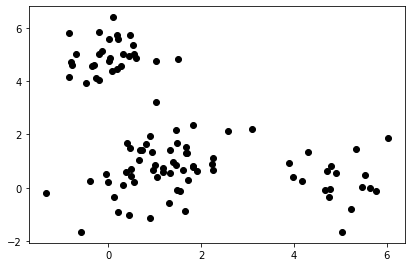

In [27]:
#Plotting Figure
plt.figure()
d = np.vstack(dat)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [28]:
np.random.seed(4)

#Initialization of parameters
chosen = np.random.choice(len(dat), 3, replace=False)
initial_mns = [dat[x] for x in chosen]
initial_covs = [np.cov(dat, rowvar=0)] * 3
initial_wgts = [1/3.] * 3

#Run EM 
results = EM(dat, initial_mns, initial_covs, initial_wgts)

In [29]:
#Function to plot contours
def plot_cntrs(dat, mns, covs, title):
    plt.figure()
    plt.plot([x[0] for x in dat], [y[1] for y in dat],'ko') # data

    delt = 0.025
    k = len(mns)
    x = np.arange(-2.0, 7.0, delt)
    y = np.arange(-2.0, 7.0, delt)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = mns[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

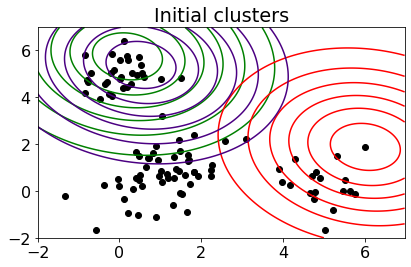

In [30]:
#Parameters after initialization
plot_cntrs(dat, initial_mns, initial_covs, 'Initial clusters')

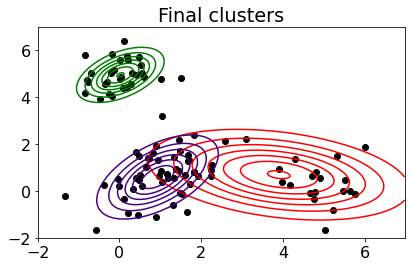

In [31]:
#Parameters after running EM to convergence
results = EM(dat, initial_mns, initial_covs, initial_wgts)
plot_cntrs(dat, results['means'], results['covariances'], 'Final clusters')

***